In [3]:
import pandas as pd
import numpy as np
import arcpy
import os
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import pydotplus
from IPython.display import Image
from matplotlib.ticker import FuncFormatter
%matplotlib inline

PATH = '.\\data'

In [2]:
source_files = [x for x in os.listdir(PATH + '\\derived_data') if x.endswith('.txt') and x != 'SF_2010_pop_block.txt']
exclude = [
    '110 - U.S. Representative, District 12.txt',
    '115 - U.S. Representative, District 13.txt',
    '120 - U.S. Representative, District 14.txt',
    '140 - Board of Supervisors, District 1.txt',
    '145 - Board of Supervisors, District 3.txt',
    '155 - Board of Supervisors, District 7.txt',
    '160 - Board of Supervisors, District 9.txt',
    '165 - Board of Supervisors, District 11.txt',
    '185 - BART Director, District 7.txt',
    '190 - BART Director, District 9.txt',
]
join_df = None
for f in source_files[:-1]:
    if f in exclude:
        continue
    df = pd.read_csv(PATH + '\\derived_data\\' + f)
    agg_dict = {x: 'sum' for x in df.columns[7:]}
    agg_dict['ballots_cast'] = 'sum'
    df = df.rename(columns={'precinct_id': 'precinctid'})
    df = df.groupby('precinctid').agg(agg_dict).reset_index()
    df = df.drop(['under_vote', 'over_vote'], axis='columns')
    df[[x for x in df.columns if x not in ('precinctid', 'ballots_cast')]] = df[[x for x in df.columns if x not in ('precinctid', 'ballots_cast')]].div(df['ballots_cast'], axis=0)
    df = df.rename(columns={x: x + '_' + ''.join([y for y in f[6:-4].lower().replace(' ', '_') if y.isalnum() or y == '_']) for x in df.columns[1:]})
    if join_df is None:
        join_df = df
    else:
        join_df = join_df.merge(df, how='left', left_on='precinctid', right_on='precinctid', suffixes=['_main', '_' + f[6:-4].lower().replace(' ', '_')])

In [3]:
feature_df = join_df.drop('precinctid', axis='columns').copy()

# Clean the feature data
feature_df = feature_df.drop([x for x in feature_df.columns if 'us_representative' in x or 'state_assembly' in x], axis='columns')
feature_df = feature_df[~pd.isnull(feature_df['yes_local_measure_u'])]
feature_df = feature_df[~pd.isnull(feature_df['dean_preston_board_of_supervisors_district_5'])]
classes = (feature_df['dean_preston_board_of_supervisors_district_5'] > feature_df['london_breed_board_of_supervisors_district_5']).astype(int)
# We'll also calculate percent dean here for when we use a regresion tree later on
endogenous = feature_df['dean_preston_board_of_supervisors_district_5'] / (feature_df['dean_preston_board_of_supervisors_district_5']+feature_df['london_breed_board_of_supervisors_district_5']) 
feature_df = feature_df.drop(['dean_preston_board_of_supervisors_district_5', 'london_breed_board_of_supervisors_district_5'], axis='columns')

## Classification Tree

In [4]:
classifier = DecisionTreeClassifier(class_weight='balanced')
classifier.fit(feature_df.values, classes)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

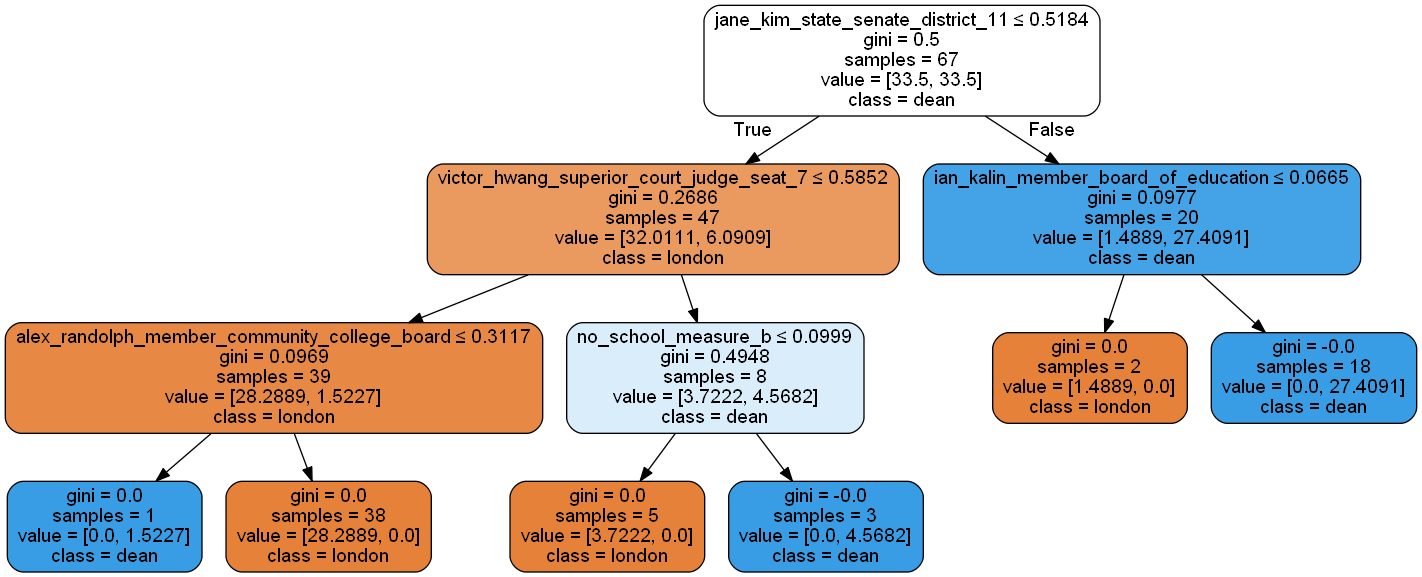

In [5]:
dot_data = tree.export_graphviz(classifier, out_file=None,
                                feature_names=feature_df.columns,
                                class_names=['london', 'dean'],
                                filled=True, rounded=True,
                                special_characters=True,
                                proportion=False
                               )  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

#### Notes
Jane being the primary split is unsurprising - the other splits make less sense. The Ian Kalin and School Measure B splits, in particular, are pretty definitely overfitted, given how low their split values are, and given how few samples fall into each of their smaller leaves. The Victor Hwang split seems plausible, both quantitatively and based on local politics, but the Alex Randolph split only has one sample in the dean leaf, so that's pointless. We could try this again with a higher minimum number of samples per leaf, but this doesn't tell us much anyway; a 51% dean precicnt and a 49% dean precinct being classified diffently is probably arbitrary and artificial to begin with. A regression tree should work better here, so we'll now try that.

## Regression Tree

In [6]:
regressor = DecisionTreeRegressor(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5
)
regressor.fit(feature_df.values, endogenous)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5, min_samples_split=10,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

#### Notes
These choices are largely arbitrary; they are to make the tree readable/useful, and prevent overfitting by forcing leafs to have at least 5 precincts.

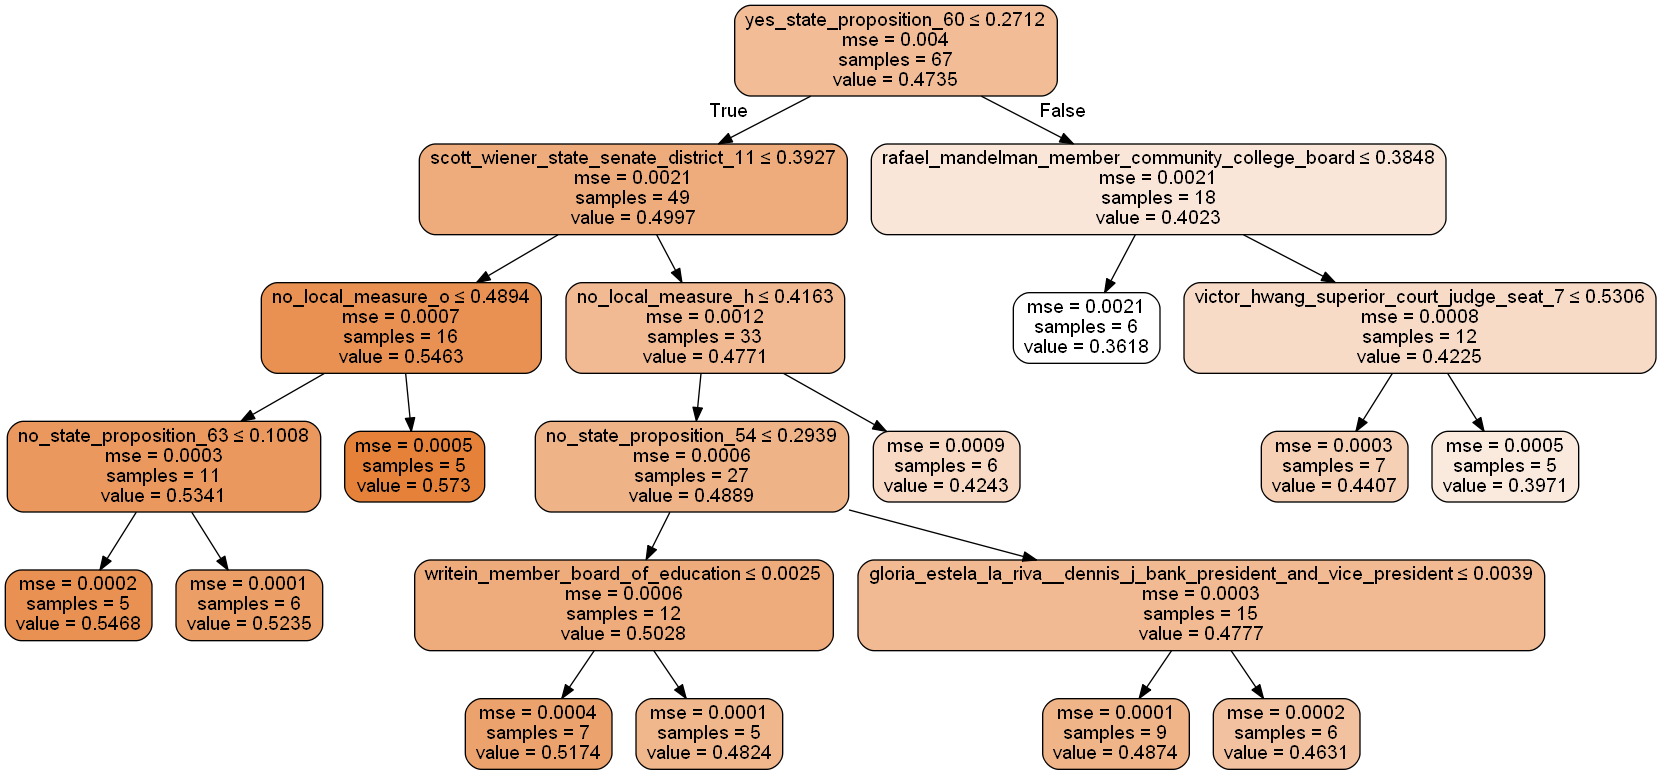

In [7]:
dot_data = tree.export_graphviz(regressor, out_file=None,
                                feature_names=feature_df.columns,
                                class_names=['london', 'dean'],
                                filled=True, rounded=True,
                                special_characters=True,
                                proportion=False
                               )  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

#### Notes
As a first pass, this looks better; it, at least conceptually/poitically, mostly makes sense. State prop 60 (mandatory condom use in porn) is an incredibly weird choice to be the most defining aspect of voters' supervisor preference, but we saw in the linear regression as well that it had the highest r^2 of any ballot measure and a steep slope, so this is consistent with that.

As next steps:
  - First and foremost should probably be to remove pointless features; I don't actually believe that voting for the PSL presidential line at a rate greater or less than .3% is a meaningful predictor of how a precinct would vote for supervisor..
  - Actually do a train/test/CV trial with this to see if it's a good predictor

In [10]:
list(feature_df.columns)

['writein_bernard_bernie_sanders__tu_president_and_vice_president',
 'gary_johnson__bill_weld_president_and_vice_president',
 'writein_jerry_white__niles_niemuth_president_and_vice_president',
 'jill_stein__ajamu_baraka_president_and_vice_president',
 'writein_evan_mcmullin__nathan_johnso_president_and_vice_president',
 'hillary_clinton__tim_kaine_president_and_vice_president',
 'writein_president_and_vice_president',
 'writein_laurence_kotlikoff__edward_l_president_and_vice_president',
 'ballots_cast_president_and_vice_president',
 'gloria_estela_la_riva__dennis_j_bank_president_and_vice_president',
 'writein_mike_maturen__juan_munoz_president_and_vice_president',
 'donald_j_trump__michael_r_pence_president_and_vice_president',
 'ballots_cast_us_senator',
 'loretta_l_sanchez_us_senator',
 'kamala_d_harris_us_senator',
 'jane_kim_state_senate_district_11',
 'scott_wiener_state_senate_district_11',
 'ballots_cast_state_senate_district_11',
 'writein_board_of_supervisors_district_5',
 'b

Easy ones are ballots cast and writeins, which we definitely don't care about:

In [13]:
feature_subset = feature_df.drop([x for x in feature_df.columns if (
            x.startswith('ballots_cast_') or
            x.startswith('writein_')
        )], axis='columns')
list(feature_subset.columns)

['gary_johnson__bill_weld_president_and_vice_president',
 'jill_stein__ajamu_baraka_president_and_vice_president',
 'hillary_clinton__tim_kaine_president_and_vice_president',
 'gloria_estela_la_riva__dennis_j_bank_president_and_vice_president',
 'donald_j_trump__michael_r_pence_president_and_vice_president',
 'loretta_l_sanchez_us_senator',
 'kamala_d_harris_us_senator',
 'jane_kim_state_senate_district_11',
 'scott_wiener_state_senate_district_11',
 'victor_hwang_superior_court_judge_seat_7',
 'paul_henderson_superior_court_judge_seat_7',
 'matt_haney_member_board_of_education',
 'mark_sanchez_member_board_of_education',
 'jill_wynns_member_board_of_education',
 'stevon_cook_member_board_of_education',
 'trevor_mcneil_member_board_of_education',
 'ian_kalin_member_board_of_education',
 'rachel_norton_member_board_of_education',
 'rob_geller_member_board_of_education',
 'phil_kim_member_board_of_education',
 'amy_bacharach_member_community_college_board',
 'tom_temprano_member_communit

While including yes and no percentages for yes/no ballot measures isn't techincally overdetermined because of under/over votes (at least as best as I understand it,) under/over votes are unimportant here - they're a non-trivial fraction of the vote, but we aren't, for now, going to try and use e.g. percentage of voters who left a measure blank as a feature. Since we're ignoring this and discarding over votes, we can just use one of the two of yes/no, since they shouldn't give very different results.

In [14]:
feature_subset = feature_subset.drop([x for x in feature_subset.columns if x.startswith('no_')], axis='columns')
list(feature_subset.columns)

['gary_johnson__bill_weld_president_and_vice_president',
 'jill_stein__ajamu_baraka_president_and_vice_president',
 'hillary_clinton__tim_kaine_president_and_vice_president',
 'gloria_estela_la_riva__dennis_j_bank_president_and_vice_president',
 'donald_j_trump__michael_r_pence_president_and_vice_president',
 'loretta_l_sanchez_us_senator',
 'kamala_d_harris_us_senator',
 'jane_kim_state_senate_district_11',
 'scott_wiener_state_senate_district_11',
 'victor_hwang_superior_court_judge_seat_7',
 'paul_henderson_superior_court_judge_seat_7',
 'matt_haney_member_board_of_education',
 'mark_sanchez_member_board_of_education',
 'jill_wynns_member_board_of_education',
 'stevon_cook_member_board_of_education',
 'trevor_mcneil_member_board_of_education',
 'ian_kalin_member_board_of_education',
 'rachel_norton_member_board_of_education',
 'rob_geller_member_board_of_education',
 'phil_kim_member_board_of_education',
 'amy_bacharach_member_community_college_board',
 'tom_temprano_member_communit

I think it's also safe to get rid of third party presidential candidates - statistical concerns with sample size notwithstanding, I don't really care if people who liked Gloria la Riva or Jill Stein also liked Dean, since that's such a tiny fraction of the voters. It's questionable if presidential race is even worth including at all, since D5 barely voted for Trump at all, but we'll leave it for now.

In [15]:
feature_subset = feature_subset.drop([
        'gary_johnson__bill_weld_president_and_vice_president',
        'jill_stein__ajamu_baraka_president_and_vice_president',
        'gloria_estela_la_riva__dennis_j_bank_president_and_vice_president'
    ], axis='columns')
list(feature_subset.columns)

['hillary_clinton__tim_kaine_president_and_vice_president',
 'donald_j_trump__michael_r_pence_president_and_vice_president',
 'loretta_l_sanchez_us_senator',
 'kamala_d_harris_us_senator',
 'jane_kim_state_senate_district_11',
 'scott_wiener_state_senate_district_11',
 'victor_hwang_superior_court_judge_seat_7',
 'paul_henderson_superior_court_judge_seat_7',
 'matt_haney_member_board_of_education',
 'mark_sanchez_member_board_of_education',
 'jill_wynns_member_board_of_education',
 'stevon_cook_member_board_of_education',
 'trevor_mcneil_member_board_of_education',
 'ian_kalin_member_board_of_education',
 'rachel_norton_member_board_of_education',
 'rob_geller_member_board_of_education',
 'phil_kim_member_board_of_education',
 'amy_bacharach_member_community_college_board',
 'tom_temprano_member_community_college_board',
 'shanell_williams_member_community_college_board',
 'alex_randolph_member_community_college_board',
 'rafael_mandelman_member_community_college_board',
 'yes_state_pr

We can probably also drop Scott Wiener; Loretta Sanchez; and Paul Henderson, since, per the argument given earlier, that information is roughly captured in the Jane Kim/Kamala Harris/Victor Hwang percentages, respectively.

In [16]:
feature_subset = feature_subset.drop([
        'loretta_l_sanchez_us_senator',
        'scott_wiener_state_senate_district_11',
        'paul_henderson_superior_court_judge_seat_7'
    ], axis='columns')
list(feature_subset.columns)

['hillary_clinton__tim_kaine_president_and_vice_president',
 'donald_j_trump__michael_r_pence_president_and_vice_president',
 'kamala_d_harris_us_senator',
 'jane_kim_state_senate_district_11',
 'victor_hwang_superior_court_judge_seat_7',
 'matt_haney_member_board_of_education',
 'mark_sanchez_member_board_of_education',
 'jill_wynns_member_board_of_education',
 'stevon_cook_member_board_of_education',
 'trevor_mcneil_member_board_of_education',
 'ian_kalin_member_board_of_education',
 'rachel_norton_member_board_of_education',
 'rob_geller_member_board_of_education',
 'phil_kim_member_board_of_education',
 'amy_bacharach_member_community_college_board',
 'tom_temprano_member_community_college_board',
 'shanell_williams_member_community_college_board',
 'alex_randolph_member_community_college_board',
 'rafael_mandelman_member_community_college_board',
 'yes_state_proposition_51',
 'yes_state_proposition_52',
 'yes_state_proposition_53',
 'yes_state_proposition_54',
 'yes_state_proposit

Although dropping some of these is perhaps dubious, given that under-votes were non-trivial for many races, this is a good starting point, and we can always add features back in if we're not getting a good result. Let's try the same regression tree procedure we used earlier:

-0.488733407453


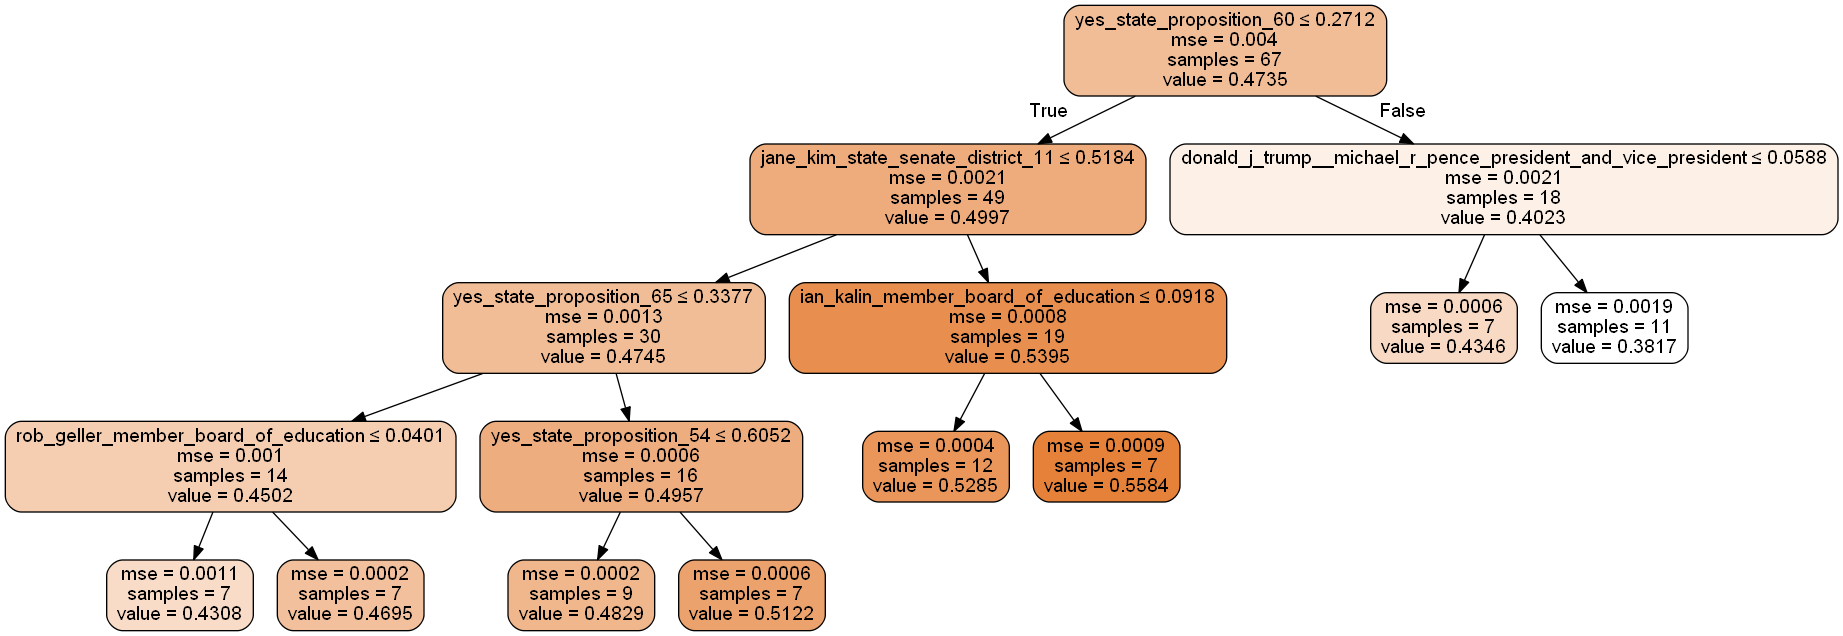

In [34]:
subset_regressor = DecisionTreeRegressor(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=7
)
subset_regressor.fit(feature_subset.values, endogenous)
dot_data = tree.export_graphviz(subset_regressor, out_file=None,
                                feature_names=feature_subset.columns,
                                class_names=['london', 'dean'],
                                filled=True, rounded=True,
                                special_characters=True,
                                proportion=False
                               )  
graph = pydotplus.graph_from_dot_data(dot_data)  
print(cross_val_score(subset_regressor, feature_subset.values, endogenous, cv=5).mean())
Image(graph.create_png())

This all seems pretty plausible; let's try actually doing a train/test with this:

In [37]:
cross_val_score(subset_regressor, feature_subset.values, endogenous, cv=5)

array([-1.39289128,  0.31180518, -1.02155682, -0.77325508,  0.43223096])

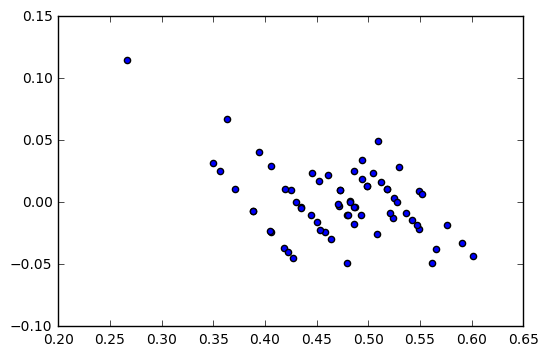

In [49]:
residuals=subset_regressor.predict(feature_subset.values)-endogenous
plt.scatter(endogenous.values, residuals)

So this shows that the model is actually *underfitting*. Basically it's missing all the districts where London crushed us, and based on how totally linear this is, it's basically just not giving a wide enough range in prediction values. We can try allowing a greater depth, and lowering the minimum number of samples per split, which was quite high.

[-1.78767204 -0.05038278 -1.31036808 -1.89306517 -0.41995751]


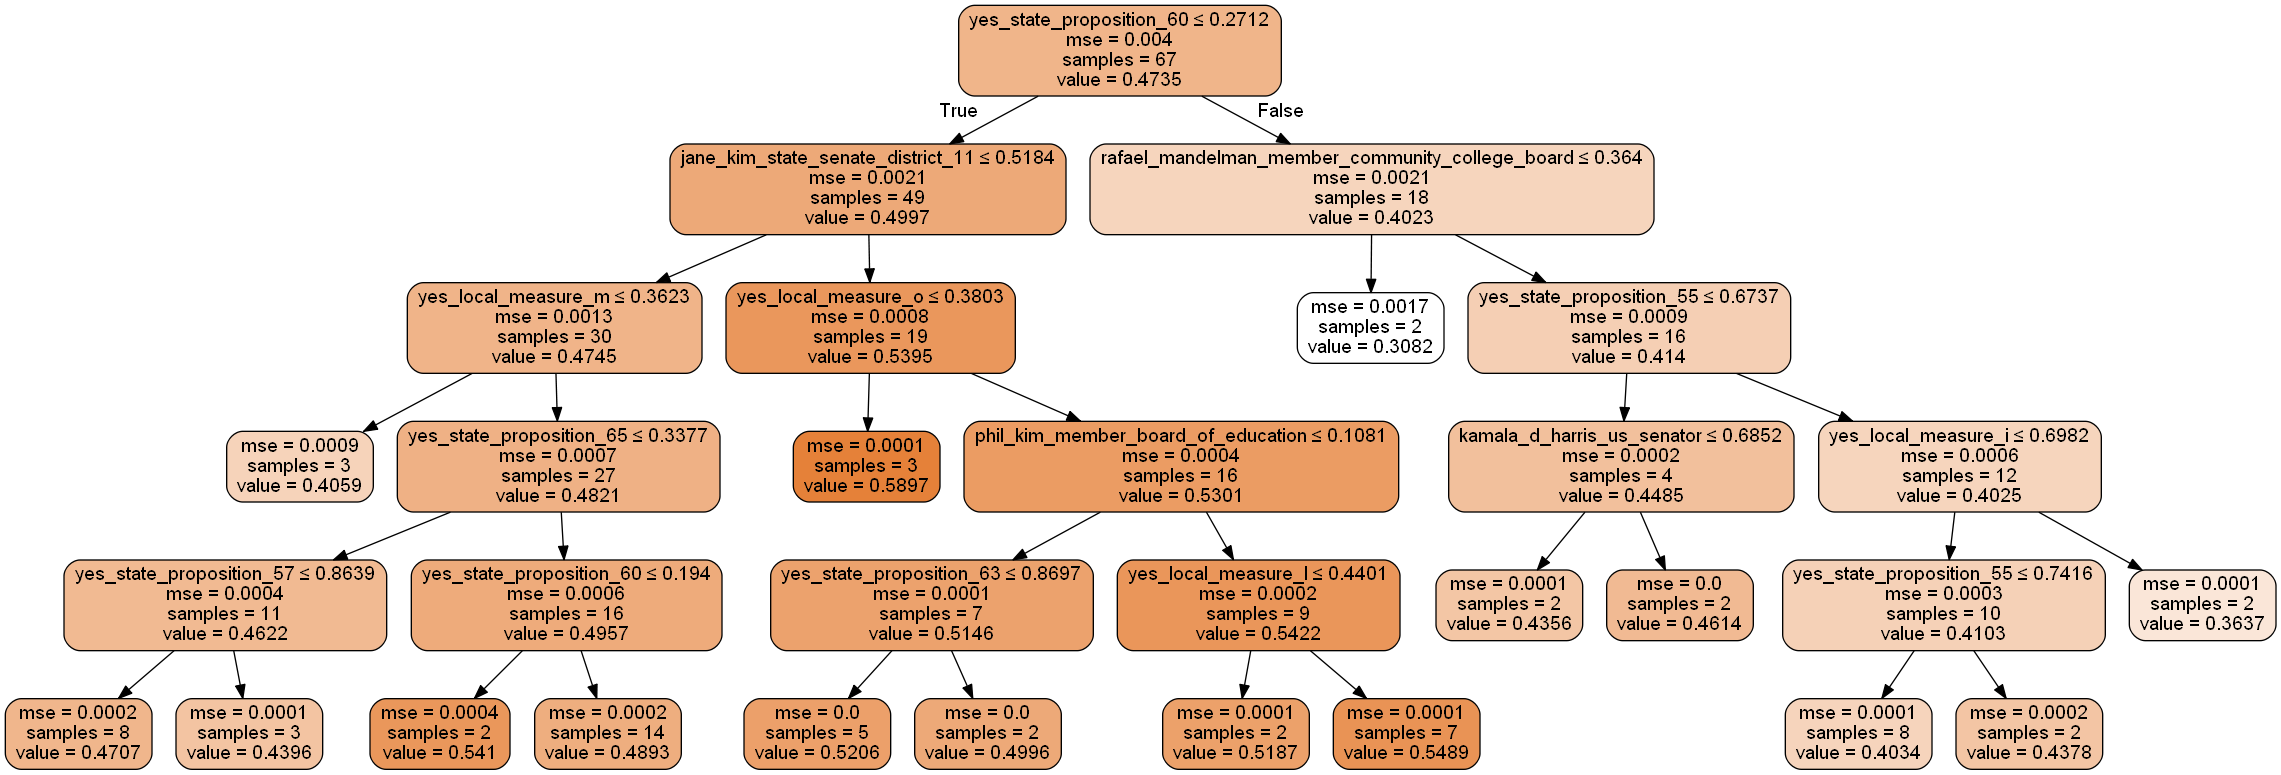

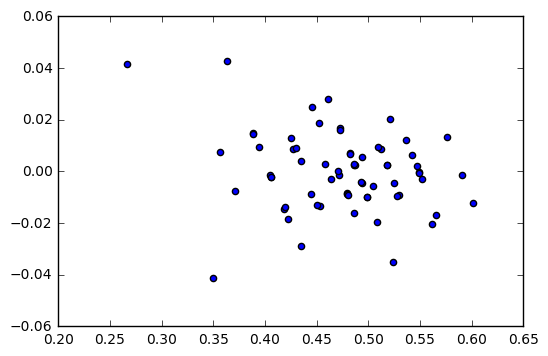

In [57]:
improved_regressor = DecisionTreeRegressor(
    max_depth=5,
    min_samples_split=3,
    min_samples_leaf=2
)
improved_regressor.fit(feature_subset.values, endogenous)
dot_data = tree.export_graphviz(improved_regressor, out_file=None,
                                feature_names=feature_subset.columns,
                                class_names=['london', 'dean'],
                                filled=True, rounded=True,
                                special_characters=True,
                                proportion=False
                               )  
graph = pydotplus.graph_from_dot_data(dot_data)  
print(cross_val_score(improved_regressor, feature_subset.values, endogenous, cv=5))
plt.scatter(endogenous.values, improved_regressor.predict(feature_subset.values)-endogenous)
Image(graph.create_png())

These residuals are much less correlated, and are roughly actually random; we have reduced the bias a good deal, but we still have high variance, as we can see from the cross validation scores. Keep trying:

Accuracy: -0.76 (+/- 1.96)


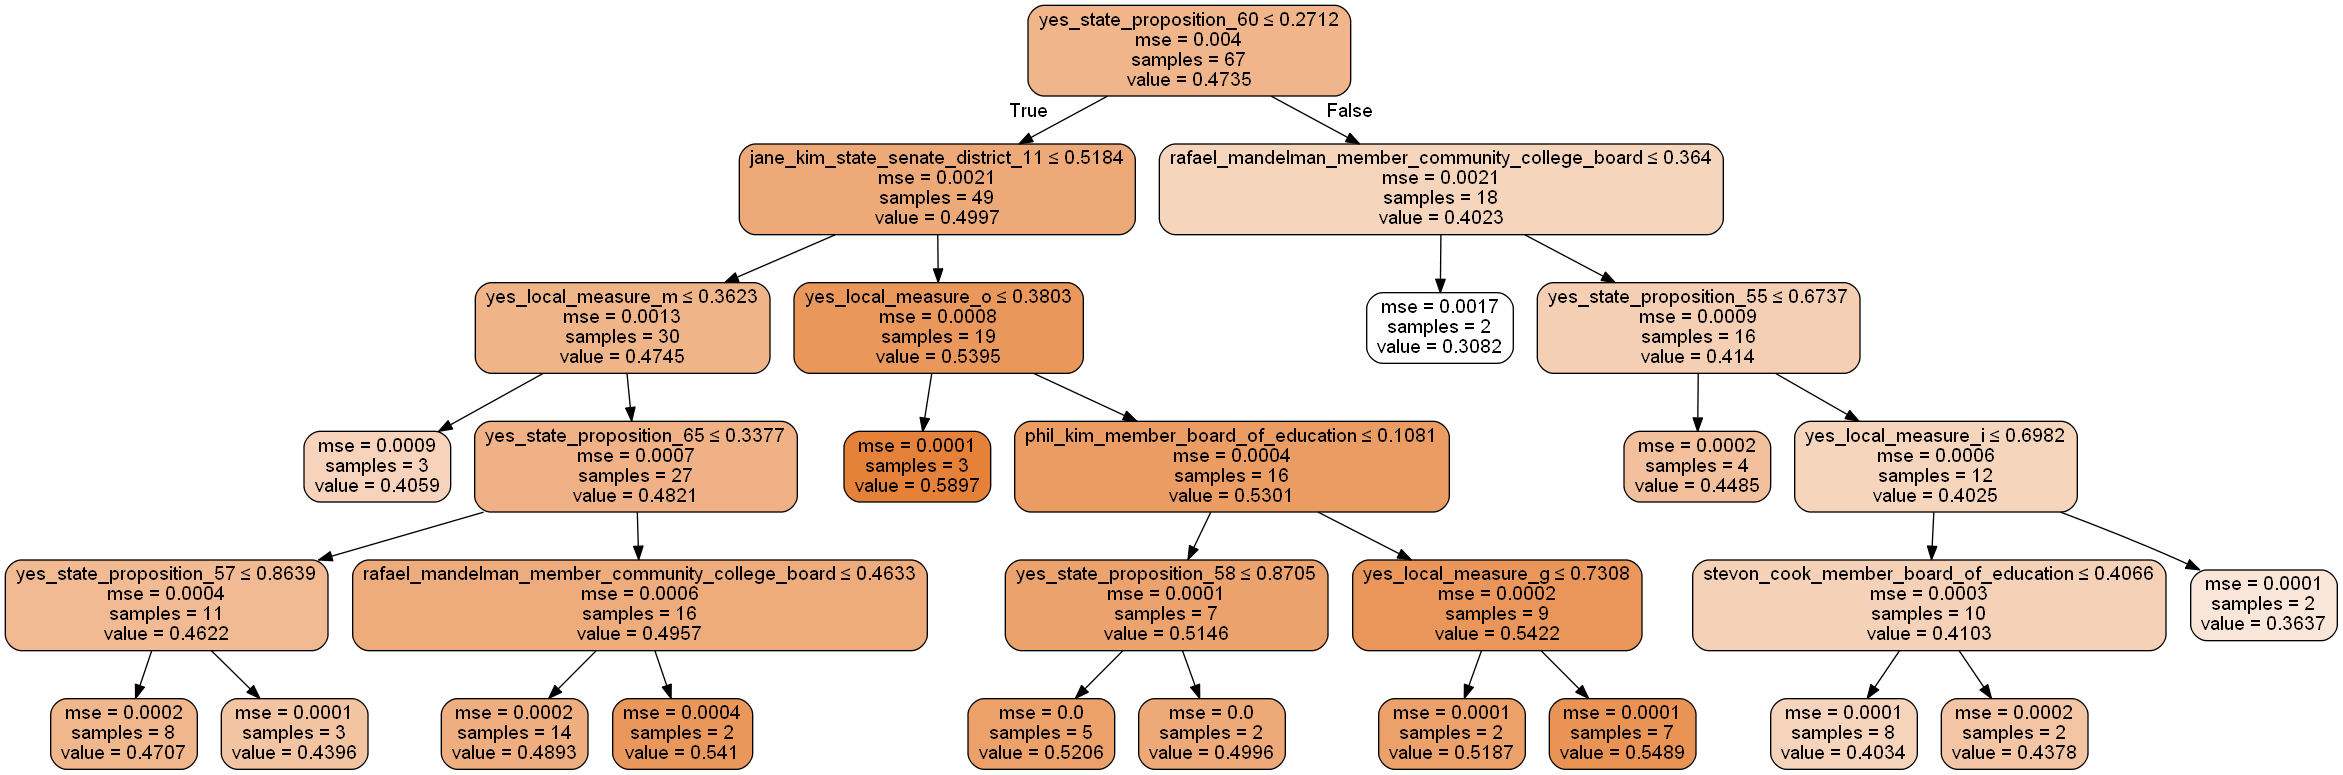

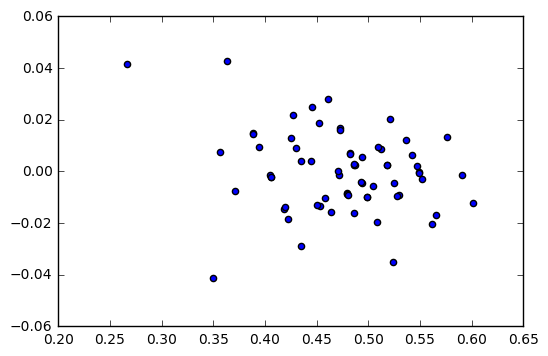

In [66]:
improved_regressor = DecisionTreeRegressor(
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2
)
improved_regressor.fit(feature_subset.values, endogenous)
dot_data = tree.export_graphviz(improved_regressor, out_file=None,
                                feature_names=feature_subset.columns,
                                class_names=['london', 'dean'],
                                filled=True, rounded=True,
                                special_characters=True,
                                proportion=False
                               )  
graph = pydotplus.graph_from_dot_data(dot_data)  
scores = cross_val_score(improved_regressor, feature_subset.values, endogenous, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
plt.scatter(endogenous.values, improved_regressor.predict(feature_subset.values)-endogenous)
Image(graph.create_png())

At this point, we have to kind of asking what we're hoping to get out of this; this is not a model that needs to be "predictive," insofar as being able to take the features of a given precinct and accurately guess what percent of the precinct voted for Dean. Its purpose is descriptive; i.e., we want to describe the characteristics of a high/low Dean precincts. From this point of view, the usefulness of the tree approach has likely reached its limit; we can pretty accurately describe precinct's votes based on its features. The fact that the tree uses binary cuts made this simple to understand, but also limits its usefulness; we would much more like to understand how dean's share of the vote varied continuously in relation to some feature or features, and for this we should use something like a regression.

In [69]:
%load_ext rpy2.ipython
%R cor(feature_subset)

ImportError: No module named rpy2.ipython